In [273]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    return pd.read_sql_query(query, conn)

/root/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


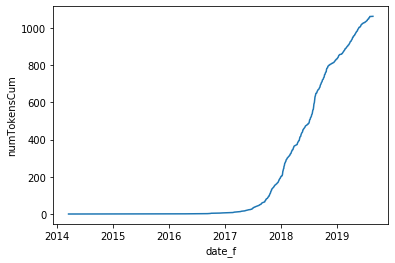

In [214]:
dateOfExchangeTrading = sql('''
SELECT 
    date, count(*) as numTokens
FROM
    (SELECT 
        token, min(date) as date 
    FROM Price
    WHERE token in (SELECT distinct token FROM ETransfer)
    group by token)
GROUP BY date
ORDER BY date
''')
dateOfExchangeTrading['numTokensCum'] = dateOfExchangeTrading['numTokens'].cumsum()
dateOfExchangeTrading["date_f"] = pd.to_datetime(dateOfExchangeTrading["date"], unit='s')

sns.lineplot(data=dateOfExchangeTrading[['date_f', 'numTokensCum']], x='date_f', y='numTokensCum')

In [21]:
sql('''SELECT count(*) FROM Etransfer where token ="foam"''')

,count(*)
0,21695


Interesting Tokens for Analysis:
- DAI: stable token, value is pegged to 1USD -> should see very little speculation
- 0x: Only useful for governance (in the future), and for paying transaction fees. Usefullness is highly debated
- Basic Attention Token: Popular used
- DigixDao: Investments in Gold
- FOAM: 

In [287]:
columns = ['type', 'operator', 'age', 'activeness', 'yield', 'parents', 'children', 'holdingSize', 'numberOfTokens']
#columns = ['holdingSize']
columnsSortBy = {
    'type': {
        'col': 'dimension',
        'ascending': False
    },
    'operator': {
        'col': 'dimension',
        'ascending': False
    },
    'age': {
        'useOrder': True,
        'col': 'dimension_ordered',
        'ascending': True   
    },
    'activeness': {
        'col': 'percEntities',
        'ascending': True
    },
    'yield': {
        'col': 'dimension',
        'ascending': True
    },
    'parents': {
        'col': 'dimension',
        'ascending': False
    },
    'children': {
        'col': 'dimension',
        'ascending': False
    },
    'holdingSize': {
        'useOrder': True,
        'col': 'dimension_ordered',
        'ascending': True
    },
    'numberOfTokens': {
        'col': 'percEntities',
        'ascending': False
    }    
}

order = {
    "under_1USD": 1,
    "under_10USD": 2,
    "under_100USD": 3,
    "under_1kUSD": 4,
    "under_10kUSD": 5,
    "under_1kkUSD": 6,
    "over_1kkUSD": 7,
    "empty": 0,
    'origin': 8,
    "week": 1,
    "month": 2,
    "quarter": 3,
    "year": 4,
    "over1Year": 5,
    "unknown": 1
}

nameChanges = {
    'numberOfTokens':'Number Of \\\\ Token Classes',
    'holdingSize': 'Holding Size',
    'loss<.1': 'Loss <10\\%',
    "loss<.67": 'Loss <67\\%',
    "loss<.9": 'Loss <90\\%',
    "steady>=.9,<1.1": 'Steady >=90\\%, <110\\%',
    "profit<1.5": 'profit <150\\%',
    "profit<10": 'profit <1\\,000\\%',
    "profit>=10": 'profit >=1\\,000\\%',
    "under_1USD": 'under 1 USD',
    "under_10USD": 'under 10 USD',
    "under_100USD": 'under 100 USD',
    "under_1kUSD": 'under 1\\,000 USD',
    "under_10kUSD": 'under 10\\,000 USD',
    "under_1kkUSD": 'under 1\,000\\,000 USD',
    "over_1kkUSD": '1\\,000\\,000 USD or more',
    "over1Year": 'Over 1 Year',
    "capp": "Centralized Application"
}
def getResultsTokenLevel(column, block, token):
#     df = sql('''
#     SELECT 
#         t.'''+column+''' as dimension, 
#         count(*) as numEntities,
#         sum(IFNULL(percentage,0)) as percCapitalization
#     FROM 
#         EntityTaxonomy t
#         INNER JOIN
#         TokenBalance b
#     ON
#         t.name = b.name
#     WHERE 
#          b.token = "'''+token+'''" and
#          blocknumber = '''+str(block)+'''
#     GROUP BY t.'''+column)

    df = sql('''
    SELECT
        '''+column+''' as dimension,
        sum(numAddresses) as numEntities,
        sum(percTokens) as percCapitalization
    FROM 
        TaxonomyResults
    WHERE token = "'''+token+'''" and blocknumber = '''+str(block)+'''
    GROUP BY '''+column
    )
    df['percEntities'] = df['numEntities'] / df['numEntities'].sum()
    if 'useOrder' in columnsSortBy[column]:
        df['dimension_ordered'] = df['dimension'].apply(lambda d:order[d])
    
    df_sorted = df.sort_values(by=columnsSortBy[column]['col'], ascending=columnsSortBy[column]['ascending'])
    return df_sorted

def prettify(rawColumnName):
    if rawColumnName in nameChanges:
        rawColumnName = nameChanges[rawColumnName]
    if '_' in rawColumnName:
        rawColumnName = rawColumnName.split('_')[0] + ' ('+rawColumnName.split('_')[1]+")"
    return rawColumnName.title()

def getTabularxRow(column, token, blocknumber):
    res = getResultsTokenLevel(column, token, blocknumber)
    res['p1'] = res['percEntities'].apply(lambda p: str(int(round(p, 2)*100))+"\%")
    res['p2'] = res['percCapitalization'].apply(lambda p: str(int(round(p, 2)*100))+"\%")
    pre = "\\makecell{"+prettify(column)+"} & " 
    cells = res[['dimension','p1','p2']].apply(lambda p: prettify(p[0])+"\\\\ ("+p[1]+", "+p[2]+")", axis=1)
    cells = cells.apply(lambda c: "\\hfill \\makecell{"+c+"}")
    main = "".join(cells)
    post = "\\hfill\\null \\\\"
    line = (pre + main + post).replace('Usd', 'USD').replace('Ico', 'ICO').replace(' 0\%', ' <1\%').replace('(0\%', '(<1\%')
    return line

def getMaxBlock():
    d = sql('''SELECT max(blocknumber) as b FROM EntityTaxonomy''')
    return d['b'][0]

def getDate(block):
    d = sql('''SELECT timestamp FROM Transfer where blocknumber='''+str(block)+' LIMIT 1')
    return datetime.utcfromtimestamp(float(d['timestamp'][0])).strftime('%Y-%m-%d %H:%M:%S')

def makeTabularx(token='ALL_ADJUSTED', block=getMaxBlock()):
    print('''\\begin{landscape}
\\begin{table}[]''')
    print('\\caption[]{Taxonomy of \\textbf{'+token+'} at block \\textbf{'+str(block)+'} (date \\textbf{'+getDate(block)+'})}')
    print('\\label{table:tax_'+token+'_'+str(block)+'}')
    print('\\begin{tabularx}{\linewidth}{|c||X|}')
    print('\\toprule')
    print('Dimension & \\hfill Characteristics \\hfill\\null \\\\')
    print('\\midrule')
    print('\\midrule')
    for column in columns:
        print(getTabularxRow(column, block, token))
        print('\\midrule')
    print('\\bottomrule')
    print('''\end{tabularx}
\end{table}
\end{landscape}''')    


In [289]:
tokens = ['0x'] #'dai', 'basic-attention-token', 'digix-gold-token'
blocks = [5088001, 6124801, 6988801, 7680001]
for token in tokens:
    for block in blocks:
        makeTabularx(token, block)
        print()

\begin{landscape}
\begin{table}[]
\caption[]{Taxonomy of \textbf{0x} at block \textbf{5088001} (date \textbf{2018-02-14 10:07:16})}
\label{table:tax_0x_5088001}
\begin{tabularx}{\linewidth}{|c||X|}
\toprule
Dimension & \hfill Characteristics \hfill\null \\
\midrule
\midrule
\makecell{Type} & \hfill \makecell{Sink (Simple)\\ (18\%, 2\%)}\hfill \makecell{Sink (Complex)\\ (25\%, 17\%)}\hfill \makecell{Mixer\\ (<1\%, <1\%)}\hfill \makecell{ICO\\ (<1\%, <1\%)}\hfill \makecell{Exchange\\ (<1\%, 12\%)}\hfill \makecell{Dilluter\\ (<1\%, <1\%)}\hfill \makecell{Connector (Simple)\\ (3\%, 22\%)}\hfill \makecell{Connector (Complex)\\ (54\%, 46\%)}\hfill \makecell{Concentrator\\ (<1\%, <1\%)}\hfill\null \\
\midrule
\makecell{Operator} & \hfill \makecell{Other\\ (100\%, 88\%)}\hfill \makecell{Centralized Application\\ (<1\%, 12\%)}\hfill\null \\
\midrule
\makecell{Age} & \hfill \makecell{Week\\ (2\%, <1\%)}\hfill \makecell{Month\\ (13\%, 2\%)}\hfill \makecell{Quarter\\ (26\%, 5\%)}\hfill \makecell{Y

\makecell{Yield} & \hfill \makecell{Loss <10\%\\ (<1\%, <1\%)}\hfill \makecell{Loss <67\%\\ (14\%, 4\%)}\hfill \makecell{Loss <90\%\\ (11\%, 13\%)}\hfill \makecell{Profit <150\%\\ (7\%, 2\%)}\hfill \makecell{Profit <1\,000\%\\ (5\%, 2\%)}\hfill \makecell{Profit >=1\,000\%\\ (<1\%, <1\%)}\hfill \makecell{Steady >=90\%, <110\%\\ (19\%, 8\%)}\hfill \makecell{Unknown\\ (44\%, 71\%)}\hfill\null \\
\midrule
\makecell{Parents} & \hfill \makecell{Source\\ (<1\%, <1\%)}\hfill \makecell{Mixer\\ (7\%, <1\%)}\hfill \makecell{ICO\\ (6\%, 1\%)}\hfill \makecell{Exchange\\ (42\%, 6\%)}\hfill \makecell{Diverse\\ (27\%, 24\%)}\hfill \makecell{Dilluter\\ (<1\%, <1\%)}\hfill \makecell{Connector (Simple)\\ (5\%, 37\%)}\hfill \makecell{Connector (Complex)\\ (12\%, 31\%)}\hfill \makecell{Concentrator\\ (<1\%, <1\%)}\hfill\null \\
\midrule
\makecell{Children} & \hfill \makecell{Sink (Simple)\\ (1\%, <1\%)}\hfill \makecell{Sink (Complex)\\ (1\%, <1\%)}\hfill \makecell{None\\ (42\%, 17\%)}\hfill \makecell{Mixer

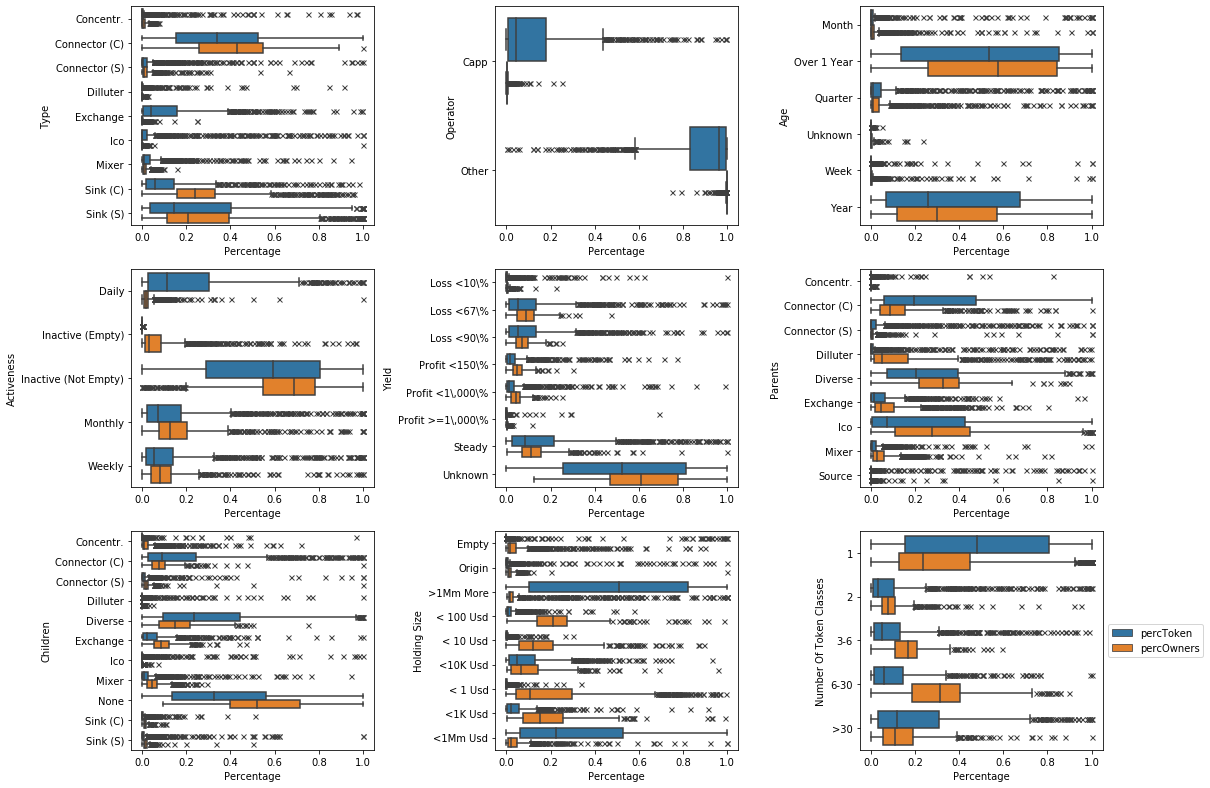

In [266]:
dimensions = ['type', 'operator', 'age', 'activeness', 'yield', 'parents', 'children', 'holdingSize', 'numberOfTokens']
    
nameChanges = {
    'numberOfTokens':'Number Of Token Classes',
    'holdingSize': 'Holding Size',
    'loss<.1': 'Loss <10\%',
    "loss<.67": 'Loss <67\%',
    "loss<.9": 'Loss <90\%',
    "steady>=.9,<1.1": 'Steady',
    "profit<1.5": 'profit <150\\%',
    "profit<10": 'profit <1\\,000\\%',
    "profit>=10": 'profit >=1\\,000\%',
    "under_1USD": '< 1 USD',
    "under_10USD": '< 10 USD',
    "under_100USD": '< 100 USD',
    "under_1kUSD": '<1k USD',
    "under_10kUSD": '<10k USD',
    "under_1kkUSD": '<1MM USD',
    "over_1kkUSD": '>1MM more',
    "over1Year": 'Over 1 Year',
    "concentrator": "concentr."
}
def prettify(rawColumnName):
    if rawColumnName in nameChanges:
        rawColumnName = nameChanges[rawColumnName]
    if '_' in rawColumnName:
        rawColumnName = rawColumnName.split('_')[0] + ' ('+rawColumnName.split('_')[1]+")"
    rawColumnName = rawColumnName.replace('(simple)', '(S)').replace('(complex)', '(C)')
    return rawColumnName.title()

def plotDimension(dimension, block = getMaxBlock()):
    data = sql('''
    SELECT 
        '''+dimension+''' as dimension, token, sum(numAddresses) as numOwners, sum(percTokens) as percToken
    FROM
        TaxonomyResults
    WHERE
        blocknumber = '''+str(block)+'''
    GROUP BY dimension, token''')
    counts = data[['token', 'numOwners']].groupby('token').sum()
    data['dimension'] = data['dimension'].apply(lambda p: prettify(p))
    data['percOwners'] = data[['token', 'numOwners']].apply(lambda d: d[1] / counts.loc[d[0], 'numOwners'], axis=1)
    date_melted = pd.melt(data, id_vars=['token', 'dimension'], value_vars=['percToken', 'percOwners'])

    
    flierprops = dict(marker='x')
    g = sns.boxplot(data=date_melted, orient="h", y='dimension', x='value', hue='variable', flierprops=flierprops)
    g.set_ylabel(prettify(dimension))
    g.set_xlabel('Percentage')
    # make box smaller
    box = g.get_position()
    g.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    if pltId == 439:
        g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        g.legend().remove()
    
pltId = 430
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
for dimension in dimensions:
    pltId += 1
    plt.subplot(pltId)
    plotDimension(dimension)
    


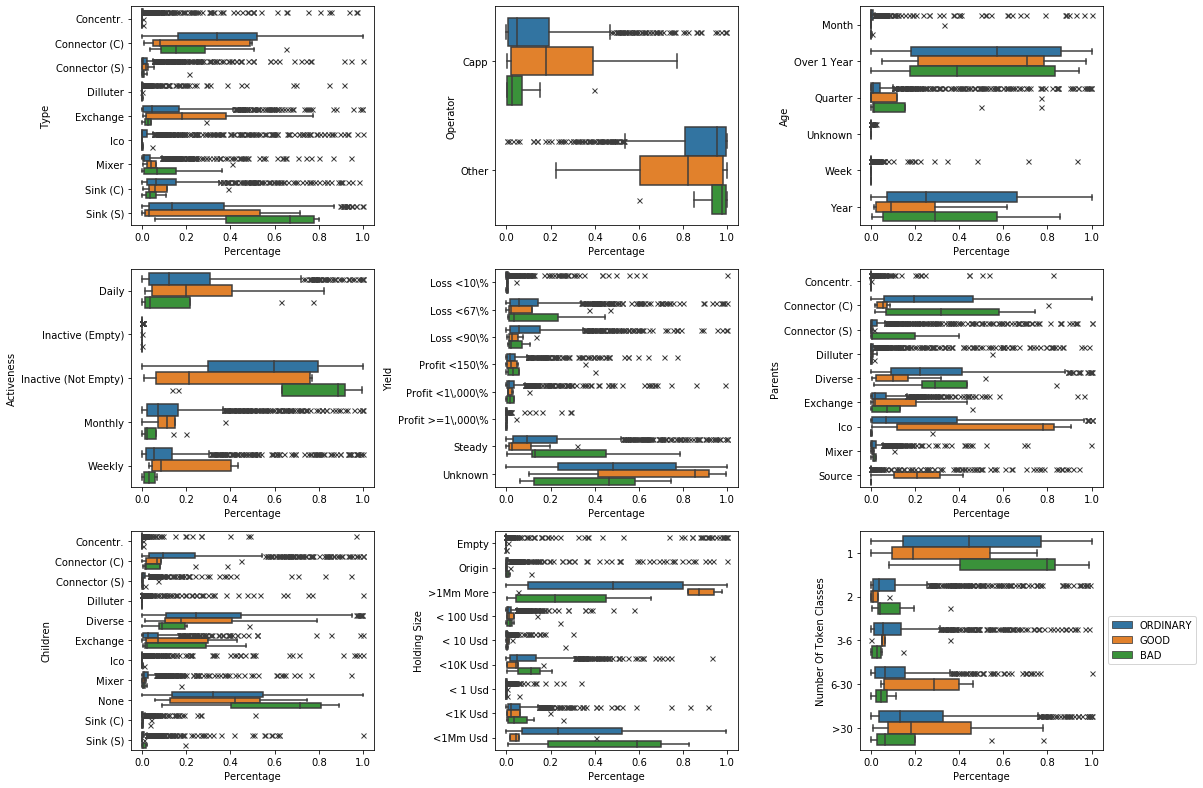

In [271]:
taxonomyDate = int(float(sql('''
SELECT timestamp FROM Etransfer
WHERE blocknumber=(SELECT max(blocknumber) FROM EntityTaxonomy)
LIMIT 1''')['timestamp'][0]) / 86400) * 86400
endDate = sql('''SELECT max(date) as d FROM Price''')['d'][0]
   

dimensions = ['type', 'operator', 'age', 'activeness', 'yield', 'parents', 'children', 'holdingSize', 'numberOfTokens']
    
nameChanges = {
    'numberOfTokens':'Number Of Token Classes',
    'holdingSize': 'Holding Size',
    'loss<.1': 'Loss <10\%',
    "loss<.67": 'Loss <67\%',
    "loss<.9": 'Loss <90\%',
    "steady>=.9,<1.1": 'Steady',
    "profit<1.5": 'profit <150\\%',
    "profit<10": 'profit <1\\,000\\%',
    "profit>=10": 'profit >=1\\,000\%',
    "under_1USD": '< 1 USD',
    "under_10USD": '< 10 USD',
    "under_100USD": '< 100 USD',
    "under_1kUSD": '<1k USD',
    "under_10kUSD": '<10k USD',
    "under_1kkUSD": '<1MM USD',
    "over_1kkUSD": '>1MM more',
    "over1Year": 'Over 1 Year',
    "concentrator": "concentr."
}
def prettify(rawColumnName):
    if rawColumnName in nameChanges:
        rawColumnName = nameChanges[rawColumnName]
    if '_' in rawColumnName:
        rawColumnName = rawColumnName.split('_')[0] + ' ('+rawColumnName.split('_')[1]+")"
    rawColumnName = rawColumnName.replace('(simple)', '(S)').replace('(complex)', '(C)')
    return rawColumnName.title()

def plotDimension(dimension, block = getMaxBlock(), timeDiff = 1):
    date = int(float(sql('''
        SELECT timestamp FROM Etransfer
        WHERE blocknumber='''+str(block)+'''
        LIMIT 1''')['timestamp'][0]) / 86400) * 86400
    finalDate = date + timeDiff * 86400
    data = sql('''
    SELECT 
        '''+dimension+''' as dimension, TaxonomyResults.token, sum(percTokens) as percToken, tk.success
    FROM
        TaxonomyResults
        INNER JOIN
        (SELECT
            endPrice.token, 
            CASE
                WHEN endPrice.price / prevPrice.price > 2 THEN "GOOD"
                WHEN endPrice.price / prevPrice.price < 0.5 THEN "BAD"
                ELSE "ORDINARY"
            END as success
        FROM
            Price endPrice
            INNER JOIN
            Price prevPrice
            ON endPrice.token = prevPrice.token
        WHERE
            prevPrice.date='''+str(date)+''' and
            endPrice.date=''' + str(finalDate)+''') tk
        ON tk.token = TaxonomyResults.token and TaxonomyResults.blocknumber = '''+str(block)+'''
        group by dimension, TaxonomyResults.token''')
    data['dimension'] = data['dimension'].apply(lambda p: prettify(p))

    flierprops = dict(marker='x')
    g = sns.boxplot(data=data, orient="h", y='dimension', x='percToken', hue='success', flierprops=flierprops)
    g.set_ylabel(prettify(dimension))
    g.set_xlabel('Percentage')
    # make box smaller
    box = g.get_position()
    g.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    if pltId == 439:
        g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        g.legend().remove()
    
pltId = 430
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
for dimension in dimensions:
    pltId += 1
    plt.subplot(pltId)
    plotDimension(dimension)
    
plt.savefig('graphs/vsPrice.pdf')

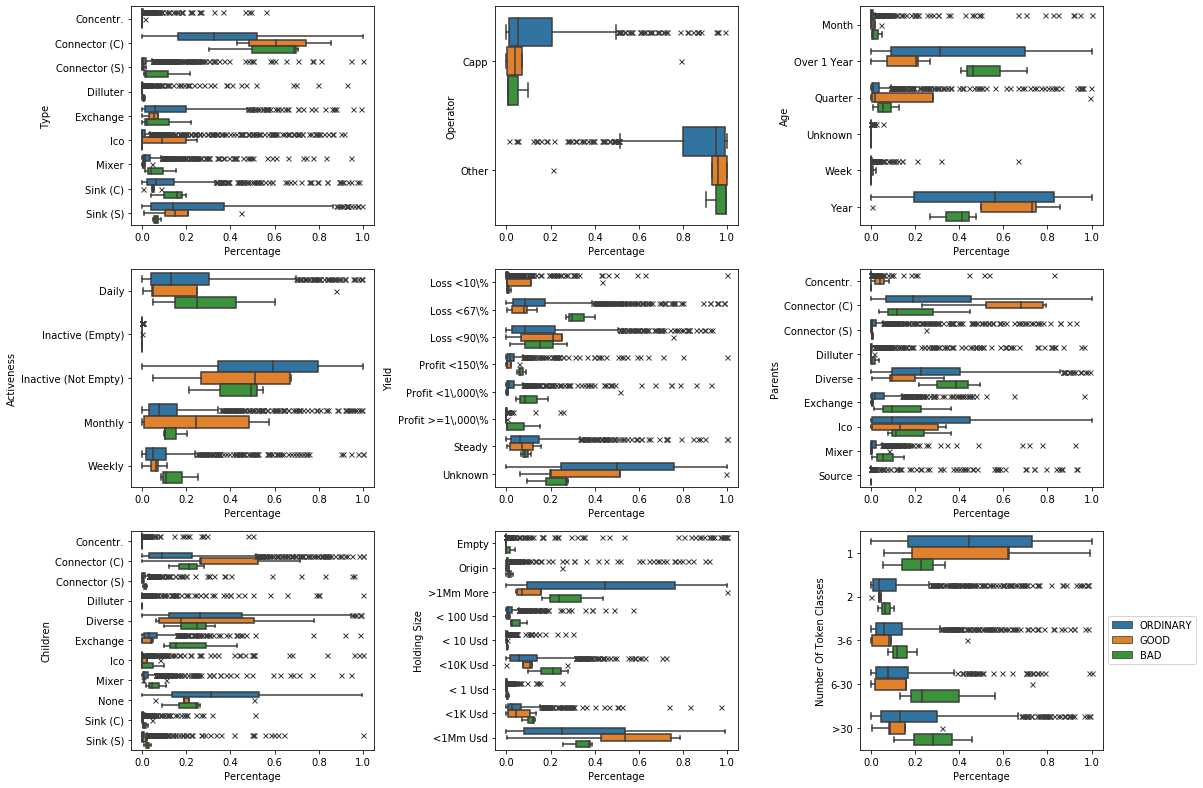

In [272]:
pltId = 430
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
for dimension in dimensions:
    pltId += 1
    plt.subplot(pltId)
    plotDimension(dimension, 7020000)

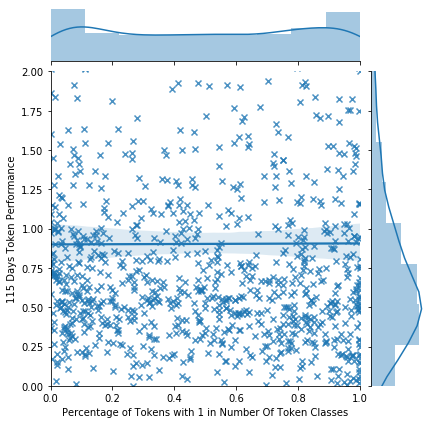

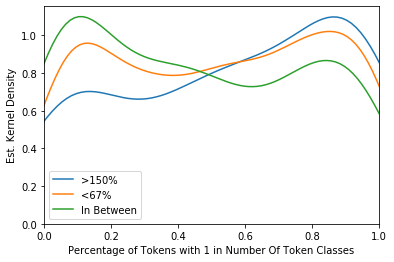

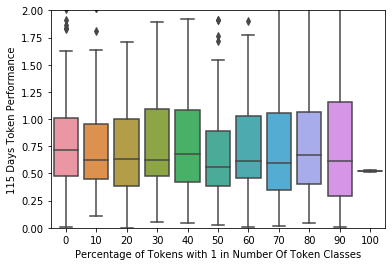

In [212]:
def plotCharacteristic(dimension, characteristic):
    data = sql('''
        SELECT 
            '''+dimension+''' as dimension, CurrentTaxonomyResults.token, sum(percTokens) as percToken, perc, success
        FROM
            CurrentTaxonomyResults
            INNER JOIN
            (SELECT
                endPrice.token, 
                CASE
                    WHEN endPrice.price / prevPrice.price > 1.5 THEN "GOOD"
                    WHEN endPrice.price / prevPrice.price < 0.67 THEN "BAD"
                    ELSE "ORDINARY"
                END as success,
                endPrice.price / prevPrice.price as perc
            FROM
                Price endPrice
                INNER JOIN
                Price prevPrice
                ON endPrice.token = prevPrice.token
            WHERE
                prevPrice.date='''+str(taxonomyDate)+''' and
                endPrice.date=''' + endDate+''') tk
            ON tk.token = CurrentTaxonomyResults.token
        WHERE '''+dimension+'''="'''+characteristic+'''"
        group by dimension, CurrentTaxonomyResults.token''')
    data['group'] = data['percToken'].apply(lambda d:int(d*10)*10)
    selectedData = data[data['perc'] < 20]
    plot = sns.jointplot(x="percToken", y="perc", data=selectedData, marker='x', kind='reg');
    plot.ax_marg_x.set_xlim(0, 1)
    plot.ax_marg_y.set_ylim(0, 2)
    plot.set_axis_labels('Percentage of Tokens with '+prettify(characteristic)+' in '+prettify(dimension),'115 Days Token Performance')
    #g.set(xlabel='common xlabel', ylabel='common ylabel')
    plt.show()

    sns.kdeplot(selectedData.loc[selectedData['success'] == 'GOOD', 'percToken'], label='>150%')
    sns.kdeplot(selectedData.loc[selectedData['success'] == 'BAD', 'percToken'], label='<67%')
    sns.kdeplot(selectedData.loc[selectedData['success'] == 'ORDINARY', 'percToken'], label='In Between')
    plt.gca().set_xlim(0,1)
    plt.gca().set_xlabel('Percentage of Tokens with '+prettify(characteristic)+' in '+prettify(dimension))
    plt.gca().set_ylabel('Est. Kernel Density')

    plt.show()

    data['group'] = data['percToken'].apply(lambda d:int(d*10)*10)

    sns.boxplot(data=selectedData, x='group', y='perc')
    plt.gca().set_ylim(0,2)
    plt.gca().set_xlabel('Percentage of Tokens with '+prettify(characteristic)+' in '+prettify(dimension))
    plt.gca().set_ylabel('115 Days Token Performance')


plotCharacteristic('numberOfTokens','1') 
    
#plotCharacteristic('parents','connector_complex') # good!
#plotCharacteristic('activeness','inactive_not empty') #meh
#plotCharacteristic('age','over1Year') #interesting

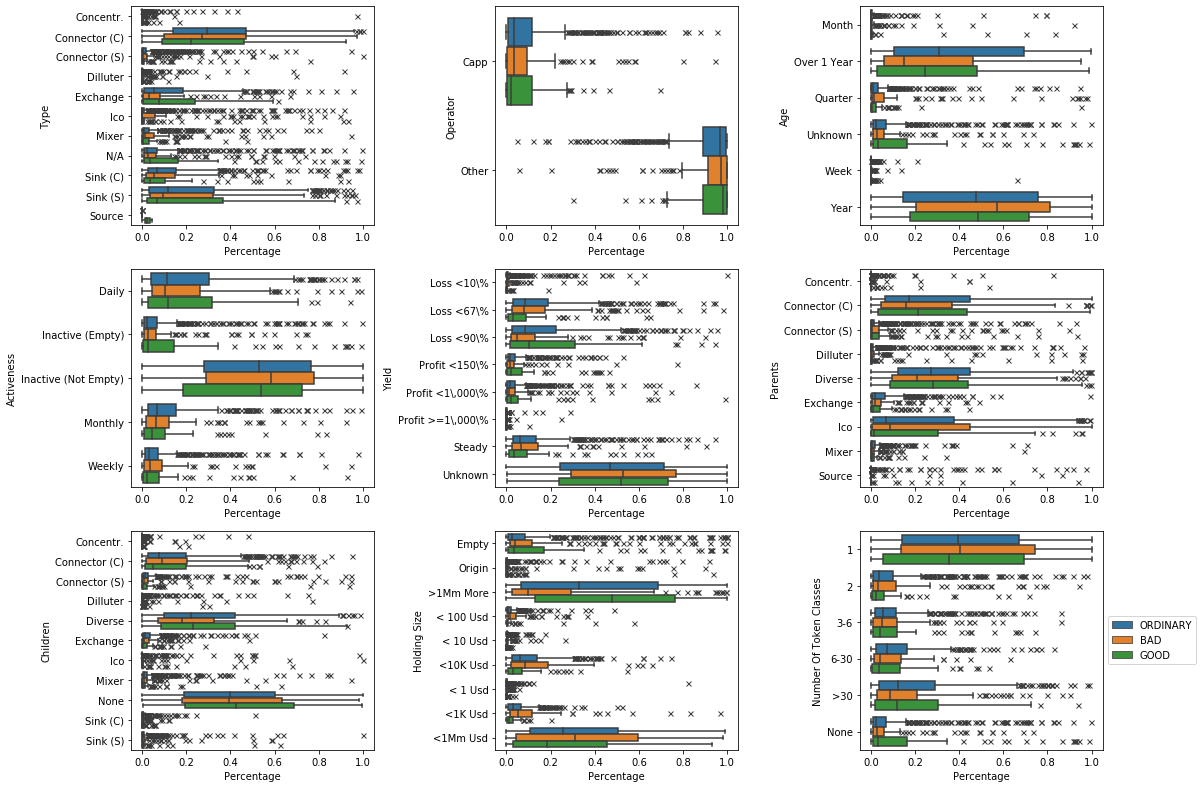

In [224]:
trainDate_start = int(float(sql('''SELECT timestamp FROM ETransfer WHERE blocknumber=7020000''')['timestamp'][0]) / 86400) * 86400
trainDate_end = trainDate_start + 118 * 86400
def plotDimension(dimension):
    data = sql('''
    SELECT 
        '''+dimension+''' as dimension, FormerTaxonomyResults.token, sum(percTokens) as percToken, tk.success
    FROM
        FormerTaxonomyResults
        INNER JOIN
        (SELECT
            endPrice.token, 
            CASE
                WHEN endPrice.price / prevPrice.price > 2 THEN "GOOD"
                WHEN endPrice.price / prevPrice.price < 0.5 THEN "BAD"
                ELSE "ORDINARY"
            END as success
        FROM
            Price endPrice
            INNER JOIN
            Price prevPrice
            ON endPrice.token = prevPrice.token
        WHERE
            prevPrice.date='''+str(trainDate_start)+''' and
            endPrice.date=''' + str(trainDate_end)+''') tk
        ON tk.token = FormerTaxonomyResults.token
    group by dimension, FormerTaxonomyResults.token''')
    data['dimension'] = data['dimension'].apply(lambda p: prettify(p))

    flierprops = dict(marker='x')
    g = sns.boxplot(data=data, orient="h", y='dimension', x='percToken', hue='success', flierprops=flierprops)
    g.set_ylabel(prettify(dimension))
    g.set_xlabel('Percentage')
    # make box smaller
    box = g.get_position()
    g.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    if pltId == 439:
        g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        g.legend().remove()
    
pltId = 430
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
for dimension in dimensions:
    pltId += 1
    plt.subplot(pltId)
    plotDimension(dimension)